In [1]:
import sys; sys.path.insert(0, '..')
from ldf.best_subset import best_n_avg
from ldf.ldf import ldf
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats as st
import itertools
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.io import loadmat
mpl.rcParams.update({'errorbar.capsize': 2})

sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":20,"axes.labelsize":20})
plt.rc('legend',fontsize=16)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Loss Discounting Framework - simulation study

## Data Generating Process
$$
y_t = x_t + \sigma_y \epsilon_t\\
x_t = \phi_x x_{t-1} + \sigma_x v_t
$$

Forecasters receive noisy signals:
$$
z_{kt} = x_t + \sigma_{zk} \nu_{kt}
$$

### Fix the seed for reproducibility

In [2]:
np.random.seed(0)

### Define DGP constants

In [3]:
phi = 0.9
sigma_x = 0.3 # 1# 
sigma_y = 0.3 # 0.5 # 
sigma_z = 0.1 # 1# 

In [4]:
K = 20  # number of forecasters
T = 2001  ## number of time steps

### Functions to generate the process

In [5]:
# Definition of time-constant Markov transition matrix
def generate_levels():
    transitions = np.asarray([-1, 0, 1])
    transition_matrix = np.array([[0.99, 0.005, 0.005],[0.005, 0.99, 0.005],[0.005, 0.005, 0.99]]) # np.array([[0.98, 0.01, 0.01],[0.01, 0.98, 0.01],[0.01, 0.01, 0.98]])
    levels = [0]
    for i in range(1,T):  
        level_index = np.where(transitions == levels[-1])[0][0]
        levels.append(np.random.choice(transitions, replace=True, p=transition_matrix[level_index]))
    return np.asarray(levels)

In [6]:
# Definition of time-varying Markov transition matrix
def generate_levels2():
    transitions = np.asarray([-1, 0, 1])
    transition_matrix = np.array([[0.99, 0.005, 0.005],[0.005, 0.99, 0.005],[0.005, 0.005, 0.99]])
    transition_matrix2 = np.array([[0.98, 0.01, 0.01],[0.01, 0.98, 0.01],[0.01, 0.01, 0.98]])
    levels = [0]
    for i in range(1,T):  
        level_index = np.where(transitions == levels[-1])[0][0]
        if i<1000:
            levels.append(np.random.choice(transitions, replace=True, p=transition_matrix[level_index]))
        else:
            levels.append(np.random.choice(transitions, replace=True, p=transition_matrix2[level_index]))
    return np.asarray(levels)

In [7]:
# Define levels of the process
levels = np.asarray([0]*50 + [-1]*50 + [1]*50 + [-1]*50 + [0]*200 + [-1]*400 + [0]*50 + [-1]*50 + [1]*50 + [-1]*10 + [1]*10 + [0]*10 + [-1]*10 + [1]*10  + [0]*50 + [1]*50 + [0]*50 + [-1]*50 + [1]*400 + [0]*50 + [-1]*50 + [1]*50 + [0]*50 + [0]*201)

def generate_dgp(levels):
    v_t = norm.rvs(size=T)
    e_t = norm.rvs(size=T)
    x = np.asarray([sigma_x * v_t[0]])
    for i in range(T-1):
        x = np.append(x, phi * x[-1] + sigma_x * v_t[i+1])
    y = phi * x + e_t * sigma_y
    y = y + levels[:T]
    return x, y

In [8]:
def get_forecasts(levels):
    x, y = generate_dgp(levels)
    z = x + norm.rvs(size=(K,T)) * sigma_z
    p = z # phi * z
    p = (p.T + np.linspace(-2,2,K)).T
    forecasts = pd.DataFrame(p)
    return forecasts, y

### Generate forecasts

In [9]:
#levels = generate_levels()
forecasts, y = get_forecasts(levels)

In [10]:
# np.save(r'D:\dev\forecast-synthesis\notebooks\ys_20230924.npy', y.reshape(2001,1))
# np.save(r'D:\dev\forecast-synthesis\notebooks\forecasts_20230924.npy', forecasts.to_numpy().reshape(2001, 1, 20))

### Forecasters's logarithmic scores

In [11]:
forecasts_lik = pd.DataFrame(norm.pdf(y, loc=forecasts.to_numpy(), scale=sigma_y))
forecasts_cdf = pd.DataFrame(norm.cdf(y, loc=forecasts.to_numpy(), scale=sigma_y))  # forecasters's cdfs

### Produce samples from forecasters

In [12]:
forecast_samples = np.empty((forecasts.shape[1], 1000, 1, forecasts.shape[0]))

for i in range(forecasts.shape[0]):
    forecast_samples[:,:,0,i] = norm.rvs(loc=forecasts.to_numpy()[i,:], scale=(sigma_y*np.ones(forecasts.to_numpy()[i,:].size)), size=(1000,forecasts.shape[1])).T

In [13]:
# import scipy.io as sio
# sio.savemat('simulation_study_20230924.mat', {'vY': y.reshape(1, T).T, 'mX': forecast_samples})

## Loss Discounting Framework

In [14]:
discount_factors = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.001])
c = 10**-20 
log_likelihoods = np.log(forecasts_lik).astype(float).to_numpy()

### 2-level LDF(softmax, argmax)

In [15]:
%%time
res_ldf_1 = ldf(log_likelihoods, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "argmax"], c=c)
res_ldf_1_df = pd.DataFrame([discount_factors, res_ldf_1["logscores"][:,-1981:].mean(axis=1)]).T
res_ldf_1_df

Wall time: 4.22 s


,0,1
0,1.000,-0.474122
1,0.990,-0.451394
2,0.950,-0.437226
3,0.900,-0.440357
4,0.800,-0.457975
5,0.700,-0.465743
6,0.600,-0.467819
7,0.500,-0.470843
8,0.400,-0.471271
9,0.300,-0.475496


### 2-level LDF(softmax, softmax)

In [16]:
%%time
res_ldf_2 = ldf(log_likelihoods, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "softmax"], c=c)
res_ldf_2_df = pd.DataFrame([discount_factors, res_ldf_2["logscores"][:,-1981:].mean(axis=1)]).T
res_ldf_2_df

Wall time: 196 ms


,0,1
0,1.000,-0.472197
1,0.990,-0.437319
2,0.950,-0.405530
3,0.900,-0.397657
4,0.800,-0.395212
5,0.700,-0.397274
6,0.600,-0.400026
7,0.500,-0.402842
8,0.400,-0.405781
9,0.300,-0.408715


In [17]:
_temp = res_ldf_2["params_weights"][0][-1981:] * discount_factors
_temp.sum(axis=1).mean()

0.6145444857566245

In [18]:
_temp = res_ldf_2["params_weights"][4][-1981:] * discount_factors
_temp.sum(axis=1).mean()

0.7105386591329546

### 3-level LDF(softmax, softmax, softmax)

In [19]:
%%time
res_ldf_3 = ldf(log_likelihoods, levels=3, discount_factors=[discount_factors, discount_factors, discount_factors], activation_functions=["softmax", "softmax", "softmax"], c=c)
res_ldf_3_df = pd.DataFrame([discount_factors, res_ldf_3["logscores"][:,-1981:].mean(axis=1)]).T
res_ldf_3_df

Wall time: 351 ms


,0,1
0,1.000,-0.396404
1,0.990,-0.387829
2,0.950,-0.389730
3,0.900,-0.392768
4,0.800,-0.394861
5,0.700,-0.395723
6,0.600,-0.396156
7,0.500,-0.396355
8,0.400,-0.396442
9,0.300,-0.396473


## N-level LDF

In [20]:
%%time
n = 20
discount_fac = [discount_factors] * n
activation_functions = ['softmax'] * n
res_ldf_inf = ldf(log_likelihoods, levels=n, discount_factors=discount_fac, activation_functions=activation_functions, c=c)
res_ldf_inf_df = pd.DataFrame([discount_factors, res_ldf_inf["logscores"][:,-1981:].mean(axis=1)]).T
res_ldf_inf_df

Wall time: 3.09 s


,0,1
0,1.000,-0.391993
1,0.990,-0.391993
2,0.950,-0.391993
3,0.900,-0.391993
4,0.800,-0.391993
5,0.700,-0.391993
6,0.600,-0.391993
7,0.500,-0.391993
8,0.400,-0.391993
9,0.300,-0.391993


#### Probability Integral Transform - analysis

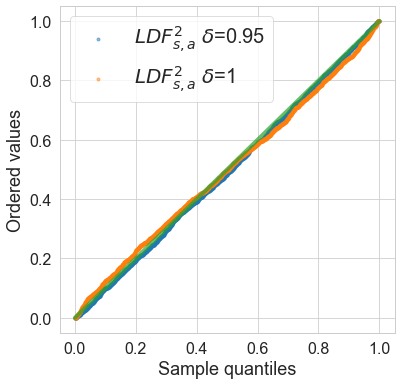

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
(x_1, y_1) , _ = st.probplot((forecasts_cdf.T[20:] * res_ldf_1["weights"][4][-1981:]).sum(axis=1), dist="uniform")
(x_2, y_2) , _ = st.probplot((forecasts_cdf.T[20:] * res_ldf_1["weights"][0][-1981:]).sum(axis=1), dist="uniform")
ax.plot([0,1], [0,1], color="tab:green", lw=4, alpha=0.7)
ax.scatter(x_1, y_1, marker="o", s=10, alpha=0.5, color="tab:blue", label=r"$LDF_{s, a}^2$ $\delta$=0.95")
ax.scatter(x_2, y_2, marker="o", s=10, alpha=0.5, color="tab:orange", label=r"$LDF_{s, a}^2$ $\delta$=1")
ax.legend()
ax.set_xlabel("Sample quantiles")
ax.set_ylabel("Ordered values")
plt.show()

## Mean predictive levels

### 2-level LDF(softmax, softmax)

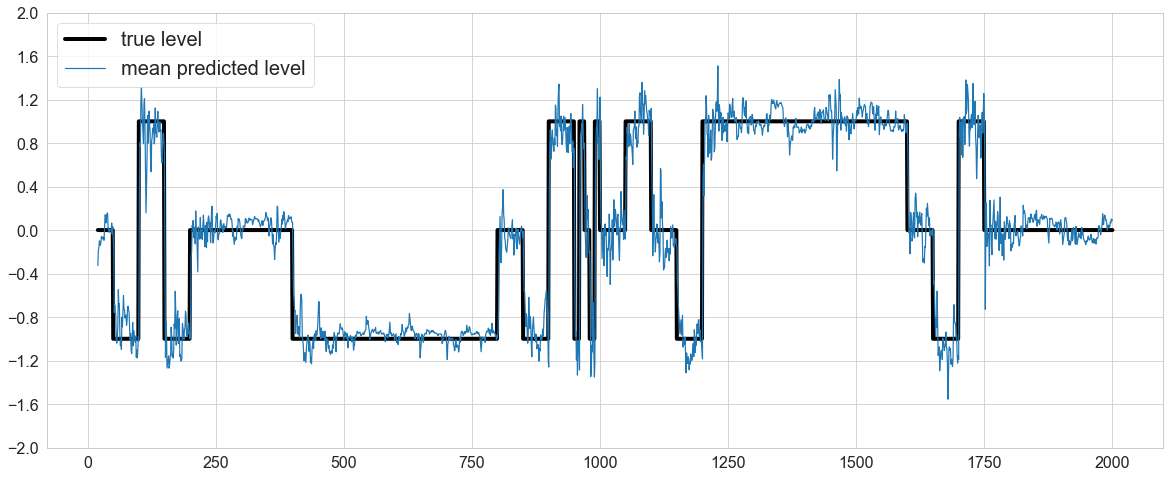

In [22]:
mean_pred_level = (np.linspace(-2,2,20) * res_ldf_2["weights"][2][-1981:]).sum(axis=1)
sns.color_palette("tab10")
fig, ax = plt.subplots(1, 1, figsize=(20,8))
lns1 = ax.plot(range(20, len(levels)), levels[20:], lw=4, label="true level", color="black")
lns2 = ax.plot(range(20, len(levels)), mean_pred_level , label="mean predicted level", color="tab:blue")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.set_ylim(-2, 2)
ax.set_yticks(np.arange(-2, 2.4, 0.4))
ax.legend(lns, labs, loc=2)
#fig.savefig("example1_softmax.pdf")

### inf-level LDF(softmax, ..., softmax)

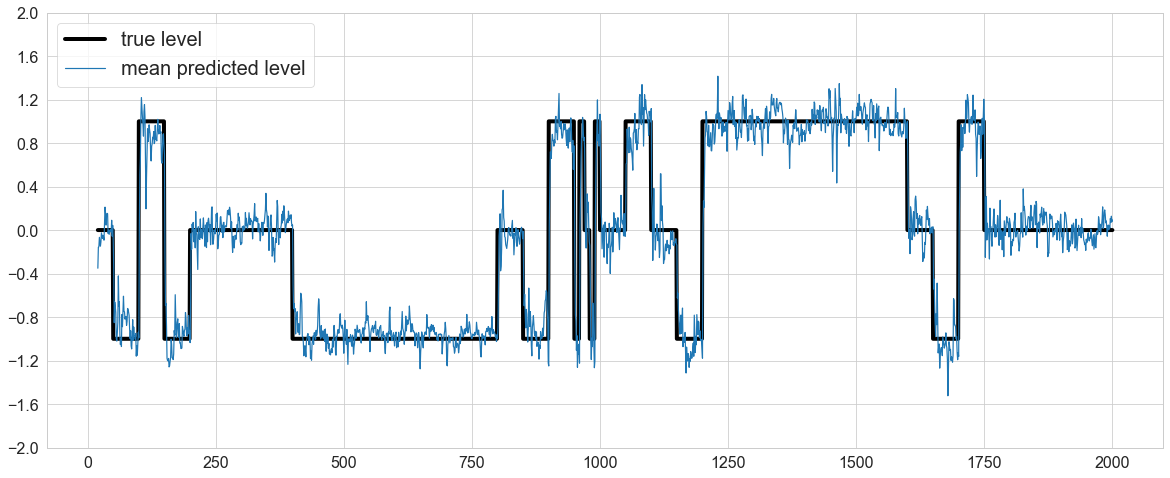

In [23]:
mean_pred_level = (np.linspace(-2,2,20) * res_ldf_inf["weights"][2][-1981:]).sum(axis=1)
sns.color_palette("tab10")
fig, ax = plt.subplots(1, 1, figsize=(20,8))
lns1 = ax.plot(range(20, len(levels)), levels[20:], lw=4, label="true level", color="black")
lns2 = ax.plot(range(20, len(levels)), mean_pred_level , label="mean predicted level", color="tab:blue")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.set_ylim(-2, 2)
ax.set_yticks(np.arange(-2, 2.4, 0.4))
ax.legend(lns, labs, loc=2)
#fig.savefig("example1_softmax.pdf")

## Discount factor through time 

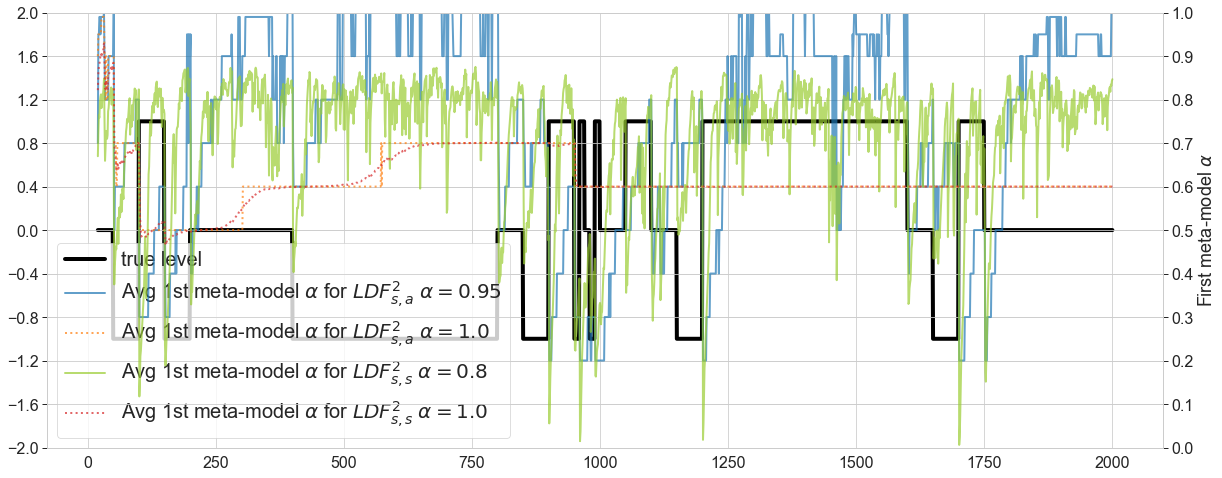

In [24]:
_temp = res_ldf_1["params_weights"][2][-1981:] * discount_factors
alpha_levels_1 = (_temp)[np.nonzero(_temp)]
_temp = res_ldf_1["params_weights"][0][-1981:] * discount_factors
alpha_levels_2 = (_temp)[np.nonzero(_temp)]
_temp = res_ldf_2["params_weights"][4][-1981:] * discount_factors
alpha_levels_3 = _temp.sum(axis=1)
_temp = res_ldf_2["params_weights"][0][-1981:] * discount_factors
alpha_levels_4 = _temp.sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(20,8))
lns1 = ax.plot(range(20, len(levels)), levels[20:], lw=4, label="true level", color="black")
ax2 = ax.twinx()
lns2 = ax2.plot(range(20, len(levels)), alpha_levels_1, c="tab:blue", alpha=0.7, label=r'Avg 1st meta-model $\alpha$ for $LDF_{s, a}^2$ $\alpha=0.95$', lw=2)
lns3 = ax2.plot(range(20, len(levels)), alpha_levels_2, c="tab:orange", alpha=0.7, label=r'Avg 1st meta-model $\alpha$ for $LDF_{s, a}^2$ $\alpha=1.0$', lw=2, ls='dotted')
lns4 = ax2.plot(range(20, len(levels)), alpha_levels_3, c="yellowgreen", alpha=0.7, label=r'Avg 1st meta-model $\alpha$ for $LDF_{s, s}^2$ $\alpha=0.8$', lw=2)
lns5 = ax2.plot(range(20, len(levels)), alpha_levels_4, c="tab:red", alpha=0.7, label=r'Avg 1st meta-model $\alpha$ for $LDF_{s, s}^2$ $\alpha=1.0$', lw=2, ls='dotted')

lns = lns1+lns2 + lns3 + lns4 + lns5
labs = [l.get_label() for l in lns]
ax.set_ylim(-2, 2)
ax.set_yticks(np.arange(-2, 2.4, 0.4))
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_ylabel("First meta-model " + r"$\alpha$")
ax.legend(lns, labs, loc=3);
fig.savefig("alphas_new.pdf")

In [25]:
alpha_levels_4.mean()

0.6145444857566245

In [26]:
alpha_levels_3.mean()

0.7105386591329546

In [27]:
alpha_levels_2.mean()

0.6163755678950024

In [28]:
alpha_levels_1.mean()

0.7517869762746089

## Diebold (2021) - best-N forecasters results

In [29]:
n = 4  # size of the team of forecasters to find
rolling_window_length = 5
comb = list(set(itertools.combinations(np.arange(K), n)))
comb = [list(t) for t in comb]

In [30]:
avg_forecasts_loglik = pd.DataFrame(np.asarray([np.log(forecasts_lik.loc[c].mean()) for c in comb]))
max_idx = avg_forecasts_loglik.rolling(rolling_window_length, min_periods=rolling_window_length, axis=1).mean().idxmax()
best_4_loglik = np.asarray([avg_forecasts_loglik.loc[idx][j] for idx, j in zip(max_idx[-1981-1:-1], avg_forecasts_loglik.columns[20:])])

In [31]:
best_combs = [comb[int(i)] for i in max_idx[-1981:]]
best_predictions = [np.asarray([forecasts.loc[i][j+1] for i in best_combs[j]]).mean() for j in range(len(max_idx[19:-1]))]
mean_pred_level_avg =  [np.asarray([np.linspace(-2,2,20)[i] for i in best_combs[j]]).mean() for j in range(len(max_idx[19:-1]))] 

In [32]:
best_4_loglik.mean()

-0.5039037308983655

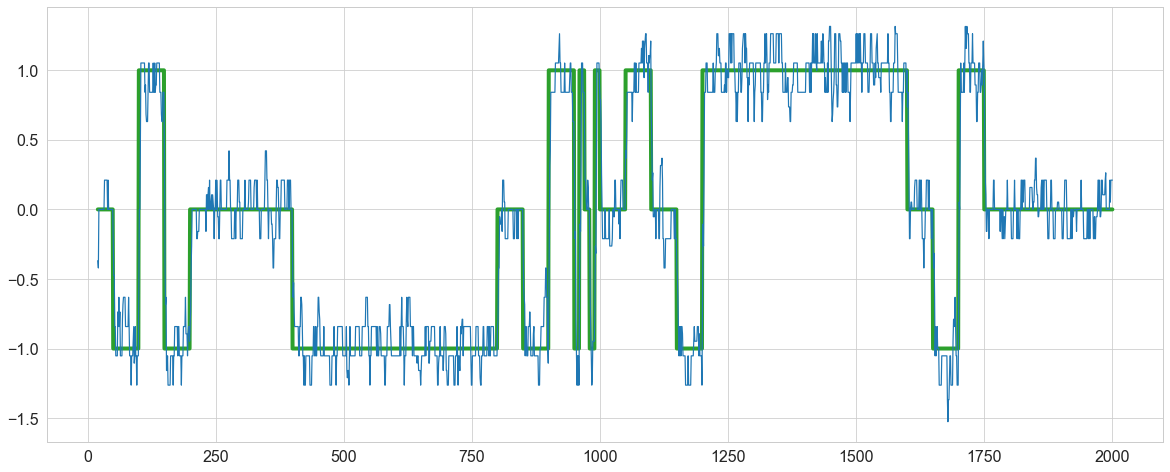

In [33]:
sns.color_palette("tab10")
fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot(range(20, len(levels)), levels[20:], lw=4, color="tab:green")
ax.plot(range(20, len(levels)), mean_pred_level_avg);

In [34]:
np.mean((mean_pred_level_avg - y[20:])**2)

0.536011537601365

## Bayesian Predictive Synthesis (McAlinn, West 2019)

In [35]:
log_lik = np.load(r"..//data//BPS//loglik_5000_95beta_95delta.npy")
expectations = np.load(r"..//data//BPS//E_p_5000_95beta_95delta.npy")
variances = np.load(r"..//data//BPS//V_p_5000_95beta_95delta.npy")
errors = np.load(r"..//data/BPS//e_5000_95beta_95delta.npy")
ys = np.load(r"..//data//BPS//ys.npy")

In [36]:
np.log(np.mean(log_lik, axis=1)).mean()

-0.7289656462920973

In [37]:
np.log(np.mean(log_lik, axis=1)).sum()

-1444.0809453046447

In [38]:
np.mean((ys[20:] - np.mean(expectations, axis=1))**2)

0.3348223436773106

### LPDR analysis

In [39]:
# DeCo_learning_estimating_results.mat - is 500mb, too big for github
deco_quantiles = loadmat(r"..//data//DeCo//DeCo_learning_estimating_results.mat")["mYPred"].mean(axis=3)

In [40]:
((deco_quantiles[-1981:, 19, 0] - y[20:])**2).max()

6.011963415384144

In [41]:
t = 1000
scales = [np.array([(deco_quantiles[t, :, 0][-i-1] - deco_quantiles[t, :, 0][i]) / (2 * norm.ppf(0.975 - i*0.025)) for i in range(19)]).mean() for t in range(2001)]

In [42]:
deco_log_lik = st.norm.logpdf(y[20:], deco_quantiles[-1981:, 19, 0], scales[-1981:])

In [43]:
deco_log_lik.mean()

-0.5561893234347433

In [44]:
false_idx = (pd.DataFrame(deco_quantiles[:,:,0]).T < y).idxmin(axis=0) # first index with false. If 0 then all are true or all are false
deco_log_lik = np.empty(T)
for i in range(T):
    if false_idx[i] == 0:
        if (pd.DataFrame(deco_quantiles[:,:,0]).T < y)[i].sum() > 1:
            deco_log_lik[i] = np.log(0.025 / (pd.DataFrame(deco_quantiles[:,:,0]).T[i].iloc[-1] - pd.DataFrame(deco_quantiles[:,:,0]).T[i].iloc[-2]))
        else:
            deco_log_lik[i] = np.log(0.025 / (pd.DataFrame(deco_quantiles[:,:,0]).T[i].iloc[1] - pd.DataFrame(deco_quantiles[:,:,0]).T[i].iloc[0]))
    else:
        deco_log_lik[i] = np.log(0.025 / (pd.DataFrame(deco_quantiles[:,:,0]).T[i].iloc[false_idx[i]] - pd.DataFrame(deco_quantiles[:,:,0]).T[i].iloc[false_idx[i]-1]))

In [45]:
deco_log_lik.mean()

-0.5228757329736884

In [46]:
dma = ldf(log_likelihoods, levels=1, discount_factors=[discount_factors], activation_functions=["softmax"], c=c)

In [47]:
np.argmax(pd.DataFrame([discount_factors, dma["logscores"][:,:250].sum(axis=1)]).T[1])

7

In [48]:
np.argmax(pd.DataFrame([discount_factors, res_ldf_2["logscores"][:,:250].sum(axis=1)]).T[1])

6

In [49]:
np.argmax(pd.DataFrame([discount_factors, res_ldf_1["logscores"][:,:250].sum(axis=1)]).T[1])

5

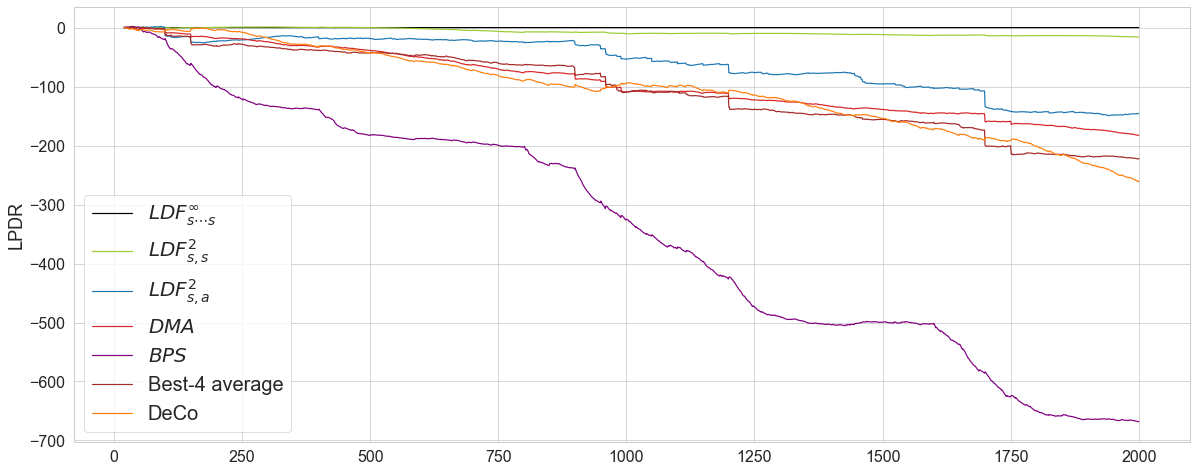

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot(range(20, len(levels)), (res_ldf_inf["logscores"][6,-1981:] - res_ldf_inf["logscores"][6,-1981:]).cumsum(), color='black', label="$LDF_{s \cdots s}^{\infty}$")
ax.plot(range(20, len(levels)), (res_ldf_2["logscores"][6,-1981:] - res_ldf_inf["logscores"][6,-1981:]).cumsum(), color='yellowgreen', label="$LDF_{s, s}^2$")
ax.plot(range(20, len(levels)), (res_ldf_1["logscores"][5,-1981:] - res_ldf_inf["logscores"][6,-1981:]).cumsum(), color='tab:blue', label="$LDF_{s, a}^2$")
ax.plot(range(20, len(levels)), (dma["logscores"][7,-1981:] - res_ldf_inf["logscores"][6,-1981:]).cumsum(), color='tab:red', label="$DMA$")
ax.plot(range(20, len(levels)), (np.log(np.mean(log_lik, axis=1)) - res_ldf_inf["logscores"][6,-1981:]).cumsum(), color='purple', label="$BPS$")
ax.plot(range(20, len(levels)), (best_4_loglik - res_ldf_inf["logscores"][6,-1981:]).cumsum(), color='brown', label="Best-4 average")#
ax.plot(range(20, len(levels)), (deco_log_lik[-1981:] - res_ldf_inf["logscores"][6,-1981:]).cumsum(), color='tab:orange', label="DeCo")
ax.set_ylabel("LPDR")
#ax.set_ylim(-20, 4)
ax.legend(loc="lower left");
# fig.savefig("simulation_lpdr.pdf")

## Full experiment

In [51]:
np.random.seed(0)
results = {"bma": [], "avg": []}
results_cumulative = {"bma": [], "avg": []}
# results = {"bma": []}
num_runs = 10
windows = [5] # rolling window length
ns = [1] # [1, 2, 3, 4, 5, 6] # [1] # 
discount_factors = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.001])
c = 10**-20 
#perfect_forecast = []
# dense settings
#alphas = np.linspace(0.2, 1.0, 81)
#deltas = np.linspace(0.2, 1.0, 81)

c = 10**-20 # 0 # 
levels = np.asarray([0]*50 + [-1]*50 + [1]*50 + [-1]*50 + [0]*200 + [-1]*400 + [0]*50 + [-1]*50 + [1]*50 + [-1]*10 + [1]*10 + [0]*10 + [-1]*10 + [1]*10  + [0]*50 + [1]*50 + [0]*50 + [-1]*50 + [1]*400 + [0]*50 + [-1]*50 + [1]*50 + [0]*50 + [0]*201)
#levels = np.ones(len(levels))
for run in tqdm(range(num_runs)):
    levels = levels # generate_levels2() # levels #generate_levels2()
    forecasts, y = get_forecasts(levels)
    forecasts_lik = norm.pdf(y, loc=forecasts, scale=sigma_y)
    #perfect_forecast.append(norm.pdf(y, loc=levels+st.norm.rvs(size=T, scale=3), scale=sigma_y))
    for n in ns:
        comb = list(set(itertools.combinations(np.arange(K), n)))
        comb = [list(t) for t in comb]
        forecasts_lik_df = pd.DataFrame(forecasts_lik)
        avg_forecasts_loglik = pd.DataFrame(np.asarray([np.log(forecasts_lik_df.loc[c].mean()) for c in comb]))
        results["avg"].append(np.log(forecasts_lik.mean(axis=0))[20:].mean())
        results_cumulative["avg"].append(np.log(forecasts_lik.mean(axis=0))[20:].sum())
        for rolling_window_length in windows:
            max_idx = avg_forecasts_loglik.rolling(rolling_window_length, min_periods=rolling_window_length, axis=1).sum().idxmax()
            best_n_loglik = np.asarray([avg_forecasts_loglik.loc[idx][j] for idx, j in zip(max_idx[-1981-1:-1], avg_forecasts_loglik.columns[20:])])
            #best_n_loglik = np.asarray([avg_forecasts_loglik.loc[idx][j+1] for idx, j in zip(max_idx[19:], avg_forecasts_loglik.columns[19:-1])])
            if "avg_" + str(n) + "_" + str(rolling_window_length) not in results.keys():
                results["avg_" + str(n) + "_" + str(rolling_window_length)] = []
                results_cumulative["avg_" + str(n) + "_" + str(rolling_window_length)] = []
            results["avg_" + str(n) + "_" + str(rolling_window_length)].append(best_n_loglik.mean())
            results_cumulative["avg_" + str(n) + "_" + str(rolling_window_length)].append(best_n_loglik.sum())
    
    log_likelihoods = np.log(forecasts_lik)
    res = ldf(log_likelihoods, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "argmax"], c=c)
    for j, delta in enumerate(discount_factors):
        if "ldfa_" + str(delta) not in results.keys():
            results["ldfa_" + str(delta)] = []
            results_cumulative["ldfa_" + str(delta)] = []
        results["ldfa_" + str(delta)].append(res["logscores"][j][19:].mean())
        results_cumulative["ldfa_" + str(delta)].append(res["logscores"][j][19:].sum())
        
        
    log_likelihoods = np.log(forecasts_lik)
    res = ldf(log_likelihoods, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "softmax"], c=c)
    for j, delta in enumerate(discount_factors):
        if "ldfs_" + str(delta) not in results.keys():
            results["ldfs_" + str(delta)] = []
            results_cumulative["ldfs_" + str(delta)] = []
        results["ldfs_" + str(delta)].append(res["logscores"][j][19:].mean())
        results_cumulative["ldfs_" + str(delta)].append(res["logscores"][j][19:].sum())
    ######    
    n = 20
    discount_fac = [discount_factors] * n
    activation_functions = ['softmax'] * n
    res = ldf(log_likelihoods, levels=n, discount_factors=discount_fac, activation_functions=activation_functions, c=c)
    for j, delta in enumerate(discount_factors):
        if "ldfss_" + str(delta) not in results.keys():
            results["ldfss_" + str(delta)] = []
            results_cumulative["ldfss_" + str(delta)] = []
        results["ldfss_" + str(delta)].append(res["logscores"][j][19:].mean())
        results_cumulative["ldfss_" + str(delta)].append(res["logscores"][j][19:].sum())
    ######
    bma_res = ldf(log_likelihoods, levels=2, discount_factors=[1, 1], activation_functions=["softmax", "argmax"], c=0)
    results["bma"].append(bma_res["logscores"][0][19:].mean())
    results_cumulative["bma"].append(bma_res["logscores"][0][19:].sum())
    
    dma_res = ldf(log_likelihoods, levels=1, discount_factors=[discount_factors], activation_functions=["softmax", "argmax"], c=c)
    for j, a in enumerate(discount_factors):
        if "dma_" + str(a) not in results.keys():
            results["dma_" + str(a)] = []
            results_cumulative["dma_" + str(a)] = []
        results["dma_" + str(a)].append(dma_res["logscores"][j][20:].mean())
        results_cumulative["dma_" + str(a)].append(dma_res["logscores"][j][20:].sum())

  0%|          | 0/10 [00:00<?, ?it/s]

In [52]:
results["avg"] = np.unique(np.array(results["avg"]))

In [53]:
df_res1 = pd.concat([pd.DataFrame(results).mean(axis=0), pd.DataFrame(results).std(axis=0), pd.DataFrame(results).sum(axis=0)], axis=1).rename(columns={0: "mean", 1: "std", 2: "sum"})
df_res1.style.format("{:.2f}")

,mean,std,sum
bma,-4.36,0.12,-43.64
avg,-1.45,0.00,-14.46
avg_1_5,-0.71,0.02,-7.09
ldfa_1.0,-0.50,0.02,-4.95
ldfa_0.99,-0.47,0.02,-4.70
ldfa_0.95,-0.46,0.02,-4.63
ldfa_0.9,-0.47,0.03,-4.71
ldfa_0.8,-0.48,0.03,-4.83
ldfa_0.7,-0.49,0.03,-4.88
ldfa_0.6,-0.49,0.03,-4.94


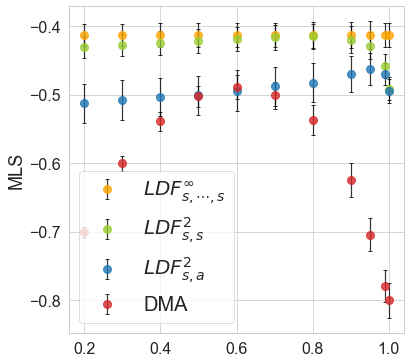

In [54]:
ldfa_df = df_res1[df_res1.index.str.contains("ldfa")]
ldfa_df.index = [float(i[1]) for i in ldfa_df.index.str.split("_")]
ldfs_df = df_res1[df_res1.index.str.contains("ldfs_")]
ldfs_df.index = [float(i[1]) for i in ldfs_df.index.str.split("_")]

ldfss_df = df_res1[df_res1.index.str.contains("ldfss")]
ldfss_df.index = [float(i[1]) for i in ldfss_df.index.str.split("_")]

dma_df = df_res1[df_res1.index.str.contains("dma")]
dma_df.index = [float(i[1]) for i in dma_df.index.str.split("_")]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.errorbar(ldfs_df.index.to_list()[:-1], ldfss_df["mean"].to_list()[:-1], yerr=ldfs_df["std"].to_list()[:-1], fmt='o', color='orange', ecolor='black', label="$LDF_{s, \cdots, s}^{\infty}$", markersize=8, alpha=0.8)
ax.errorbar(ldfs_df.index.to_list()[:-1], ldfs_df["mean"].to_list()[:-1], yerr=ldfs_df["std"].to_list()[:-1], fmt='o', color='yellowgreen', ecolor='black', label="$LDF_{s, s}^2$", markersize=8, alpha=0.8)
ax.errorbar(ldfa_df.index.to_list()[:-1], ldfa_df["mean"].to_list()[:-1], yerr=ldfa_df["std"].to_list()[:-1], fmt='o', color='tab:blue', ecolor='black', label="$LDF_{s, a}^2$", markersize=8, alpha=0.8)
ax.errorbar(dma_df.index.to_list()[:-1], dma_df["mean"].to_list()[:-1], yerr=dma_df["std"].to_list()[:-1], fmt='o', color='tab:red', ecolor='black', label="DMA", markersize=8, alpha=0.8)
ax.set_ylabel(r"MLS")
ax.legend(loc="lower left");
fig.savefig("simulation_delta_alpha.pdf")

In [55]:
results_cumulative["avg"] = np.unique(np.array(results_cumulative["avg"]))

In [56]:
df_res2 = pd.concat([pd.DataFrame(results_cumulative).mean(axis=0), pd.DataFrame(results_cumulative).std(axis=0), pd.DataFrame(results_cumulative).sum(axis=0)], axis=1).rename(columns={0: "mean", 1: "std", 2: "sum"})
df_res2.style.format("{:.2f}")

,mean,std,sum
bma,-8650.01,242.51,-86500.09
avg,-2864.22,4.23,-28642.23
avg_1_5,-1404.45,45.73,-14044.47
ldfa_1.0,-981.47,35.53,-9814.75
ldfa_0.99,-930.94,32.32,-9309.44
ldfa_0.95,-917.20,45.99,-9171.97
ldfa_0.9,-932.56,51.72,-9325.58
ldfa_0.8,-956.86,55.72,-9568.60
ldfa_0.7,-967.33,57.05,-9673.32
ldfa_0.6,-979.85,58.37,-9798.48


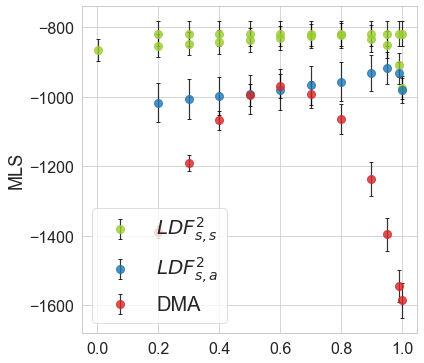

In [57]:
ldfa_df = df_res2[df_res2.index.str.contains("ldfa")]
ldfa_df.index = [float(i[1]) for i in ldfa_df.index.str.split("_")]
ldfs_df = df_res2[df_res2.index.str.contains("ldfs")]
ldfs_df.index = [float(i[1]) for i in ldfs_df.index.str.split("_")]
dma_df = df_res2[df_res2.index.str.contains("dma")]
dma_df.index = [float(i[1]) for i in dma_df.index.str.split("_")]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.errorbar(ldfs_df.index.to_list()[:-1], ldfs_df["mean"].to_list()[:-1], yerr=ldfs_df["std"].to_list()[:-1], fmt='o', color='yellowgreen', ecolor='black', label="$LDF_{s, s}^2$", markersize=8, alpha=0.8)
ax.errorbar(ldfa_df.index.to_list()[:-1], ldfa_df["mean"].to_list()[:-1], yerr=ldfa_df["std"].to_list()[:-1], fmt='o', color='tab:blue', ecolor='black', label="$LDF_{s, a}^2$", markersize=8, alpha=0.8)
ax.errorbar(dma_df.index.to_list()[:-1], dma_df["mean"].to_list()[:-1], yerr=dma_df["std"].to_list()[:-1], fmt='o', color='tab:red', ecolor='black', label="DMA", markersize=8, alpha=0.8)
ax.set_ylabel(r"MLS")
ax.legend(loc="lower left");